In [27]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate
import tensorflow_probability as tfp
import numpy as np
import os
import importlib
import logging
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [4]:
training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v2.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta, mumu, emu, etau
target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                          np.sin(training_data["delta"]/180*np.pi), np.cos(training_data["delta"]/180*np.pi),
                         training_data["mumu"], training_data["emu"],training_data["etau"]])

x_train = data_all
y_train = target

x_train_poisson = np.random.poisson(x_train)/1000

In [5]:
gaussian_number = 10
latent_dim = 4
latent_dim_2 = len(y_train[0])
x_parameter_node = [256, 256, 256]
x_spectrum_node = x_parameter_node
x_latent_node = x_parameter_node
kl_scaling = 1e+4
lr = 0.00002

In [47]:
z2_weight = [0.1, 0.5]
z2_mean = tf.constant([[0.1, 2.0], [0.1, -10.0]])
temp_var_r1 = tf.constant([[0.1, 2.0], [0.1, 2.0]])

In [48]:
bimix_gauss = tfp.distributions.MixtureSameFamily(
                mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                components_distribution=tfp.distributions.MultivariateNormalDiag(
                loc=z2_mean,
                scale_diag=tf.sqrt(temp_var_r1)))

In [49]:
arr = bimix_gauss.sample(sample_shape=10000)

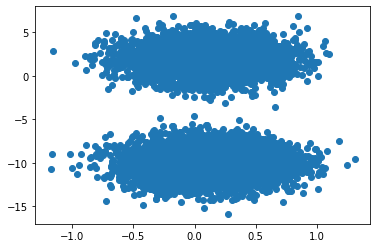

In [50]:
plt.scatter(arr[:,0], arr[:, 1])
plt.show()

In [30]:
s = mvn_q.sample(sample_shape=(1000))


In [35]:
s.shape

TensorShape([1000, 2])

In [31]:
import matplotlib.pyplot as plt

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-12.170112 ,  -9.4691515,  -6.768191 ,  -4.06723  ,  -1.3662698,
          1.3346906,   4.035651 ,   6.7366114,   9.437572 ,  12.138533 ,
         14.839493 ], dtype=float32),
 <a list of 1000 BarContainer objects>)

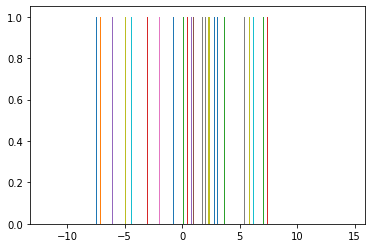

In [33]:
plt.hist(s)
plt.show()

In [20]:
SMALL_CONSTANT = 1e-12

z1_mean, z1_log_var = [1, 2], [3, 4]

temp_var_q = SMALL_CONSTANT + tf.exp(z1_log_var)
mvn_q = tfp.distributions.MultivariateNormalDiag(
                loc=z1_mean,
                scale_diag=tf.sqrt(temp_var_q))

z1 = mvn_q.sample()

z2_mean, z2_log_var, z2_weight = [1, 2], [3, 4], [5, 6]

z2_mean = tf.reshape(z2_mean, (-1, gaussian_number, latent_dim))
z2_log_var = tf.reshape(z2_log_var, (-1, gaussian_number, latent_dim))
z2_weight = tf.reshape(z2_weight, (-1, gaussian_number))

temp_var_r1 = SMALL_CONSTANT + tf.exp(z2_log_var)
bimix_gauss = tfp.distributions.MixtureSameFamily(
                mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                components_distribution=tfp.distributions.MultivariateNormalDiag(
                loc=z2_mean,
                scale_diag=tf.sqrt(temp_var_r1)))

reconstruction_mean, reconstruction_var = self.decoder([z1, x[1]])     

temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag= tf.sqrt(temp_var_r2))

kl_loss = tf.reduce_mean(mvn_q.log_prob(z1) - bimix_gauss.log_prob(z1))*kl_scaling
reconstruction_loss = -1.0*tf.reduce_mean(reconstruction_parameter.log_prob(y))

total_loss = reconstruction_loss + kl_loss

InvalidArgumentError: Value for attr 'T' of int32 is not in the list of allowed values: bfloat16, half, float, double, complex64, complex128
	; NodeDef: {{node Exp}}; Op<name=Exp; signature=x:T -> y:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128]> [Op:Exp]

Encoder 1 (parameter + spectrum)

In [3]:
def encoder1(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node):
    encoder_parameter_inputs = layers.Input(shape=(len(y_train[0]),),name = 'encoder_parameter_inputs')
    x_parameter = layers.Dense(x_parameter_node[0], activation="relu", name = 'dense_parameter_1')(encoder_parameter_inputs)
    x_parameter = layers.Dense(x_parameter_node[1], activation="relu", name = 'dense_parameter_2')(x_parameter)
    x_parameter = layers.Dense(x_parameter_node[2], activation="relu", name = 'dense_parameter_3')(x_parameter)

    encoder_spectrum_inputs = layers.Input(shape=(144),name = 'encoder_spectrum_inputs')
    x_spectrum = layers.Dense(x_spectrum_node[0], activation="relu", name = 'dense_spectrum_1')(encoder_spectrum_inputs)
    x_spectrum = layers.Dense(x_spectrum_node[1], activation="relu", name = 'dense_spectrum_2')(x_spectrum)
    x_spectrum = layers.Dense(x_spectrum_node[2], activation="relu", name = 'dense_spectrum_3')(x_spectrum)

    mergedOut_Encoder_1 = Concatenate()([x_parameter,x_spectrum])

    z_mean = layers.Dense(latent_dim, name="z_mean")(mergedOut_Encoder_1)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(mergedOut_Encoder_1)

    return keras.Model(inputs=[encoder_parameter_inputs, encoder_spectrum_inputs], outputs=[z_mean, z_log_var], name="encoder_1")

Encoder2 (spectrum)

In [4]:
def encoder2(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node):
    encoder_spectrum_inputs = layers.Input(shape=(len(x_train[0]),),name = 'encoder_spectrum_inputs')
    x_spectrum = layers.Dense(x_spectrum_node[0], activation="relu", name = 'dense_spectrum_1')(encoder_spectrum_inputs)
    x_spectrum = layers.Dense(x_spectrum_node[1], activation="relu", name = 'dense_spectrum_2')(x_spectrum)
    x_spectrum = layers.Dense(x_spectrum_node[2], activation="relu", name = 'dense_spectrum_3')(x_spectrum)

    z_mean = layers.Dense(guassian_number*latent_dim, name="z_mean")(x_spectrum)
    z_log_var = layers.Dense(guassian_number*latent_dim, name="z_log_var")(x_spectrum)
    z_weight = layers.Dense(guassian_number, name="z_weight")(x_spectrum)

    return keras.Model(inputs=encoder_spectrum_inputs, outputs=[z_mean, z_log_var, z_weight], name="encoder_2")

Decoder (latent + spectrum)

In [5]:
def decoder(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node):
    decoder_latent_inputs = keras.Input(shape=(latent_dim,),name = 'decoder_latent_inputs')
    x_latent = layers.Dense(x_latent_node[0], activation="relu", name = 'dense_1')(decoder_latent_inputs)
    x_latent = layers.Dense(x_latent_node[1], activation="relu", name = 'dense_2')(x_latent)
    x_latent = layers.Dense(x_latent_node[2], activation="relu", name = 'dense_3')(x_latent)

    decoder_spectrum_inputs = layers.Input(shape=(144,),name = 'decoder_spectrum_inputs')
    x_spectrum = layers.Dense(x_spectrum_node[0], activation="relu", name = 'dense_spectrum_1')(decoder_spectrum_inputs)
    x_spectrum = layers.Dense(x_spectrum_node[1], activation="relu", name = 'dense_spectrum_2')(x_spectrum)
    x_spectrum = layers.Dense(x_spectrum_node[2], activation="relu", name = 'dense_spectrum_3')(x_spectrum)

    mergedOut_Decoder = Concatenate()([x_latent,x_spectrum])

    z2_mean = layers.Dense(latent_dim_2, name="z_mean")(mergedOut_Decoder)
    z2_log_var = layers.Dense(latent_dim_2, name="z_log_var")(mergedOut_Decoder)

    return keras.Model(inputs=[decoder_latent_inputs, decoder_spectrum_inputs], outputs=[z2_mean, z2_log_var], name="decoder")

In [6]:
class CVAE(keras.Model):
    def __init__(self, guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node, kl_scaling, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder1 = encoder1(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node)
        self.encoder2 = encoder2(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node)
        self.decoder = decoder(guassian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.val_kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,

                ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            SMALL_CONSTANT = 1e-12
            
            z1_mean, z1_log_var = self.encoder1(x)
            
            temp_var_q = SMALL_CONSTANT + tf.exp(z1_log_var)
            mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=z1_mean,
                          scale_diag=tf.sqrt(temp_var_q))
            
            z1 = mvn_q.sample()
            
            z2_mean, z2_log_var, z2_weight = self.encoder2(x[1])

            z2_mean = tf.reshape(z2_mean, (-1, gaussian_number, latent_dim))
            z2_log_var = tf.reshape(z2_log_var, (-1, gaussian_number, latent_dim))
            z2_weight = tf.reshape(z2_weight, (-1, gaussian_number))
            
            temp_var_r1 = SMALL_CONSTANT + tf.exp(z2_log_var)
            bimix_gauss = tfp.distributions.MixtureSameFamily(
                          mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                          components_distribution=tfp.distributions.MultivariateNormalDiag(
                          loc=z2_mean,
                          scale_diag=tf.sqrt(temp_var_r1)))
            
            reconstruction_mean, reconstruction_var = self.decoder([z1, x[1]])     
            
            temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
            reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                                     loc=reconstruction_mean,
                                     scale_diag= tf.sqrt(temp_var_r2))

            kl_loss = tf.reduce_mean(mvn_q.log_prob(z1) - bimix_gauss.log_prob(z1))*kl_scaling
            reconstruction_loss = -1.0*tf.reduce_mean(reconstruction_parameter.log_prob(y))
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def evaluate(self,
               x=None,
               y=None,
               batch_size=None,
               verbose=1,
               sample_weight=None,
               steps=None,
               callbacks=None,
               max_queue_size=10,
               workers=1,
               use_multiprocessing=False,
               return_dict=False,
               **kwargs):
        SMALL_CONSTANT = 1e-12
        
        z1_mean, z1_log_var = self.encoder1(x)
        
        temp_var_q = SMALL_CONSTANT + tf.exp(z1_log_var)
        mvn_q = tfp.distributions.MultivariateNormalDiag(
                        loc=z1_mean,
                        scale_diag=tf.sqrt(temp_var_q))
        
        z1 = mvn_q.sample()
        
        z2_mean, z2_log_var, z2_weight = self.encoder2(x[1])

        z2_mean = tf.reshape(z2_mean, (-1, gaussian_number, latent_dim))
        z2_log_var = tf.reshape(z2_log_var, (-1, gaussian_number, latent_dim))
        z2_weight = tf.reshape(z2_weight, (-1, gaussian_number))
        
        temp_var_r1 = SMALL_CONSTANT + tf.exp(z2_log_var)
        bimix_gauss = tfp.distributions.MixtureSameFamily(
                        mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                        components_distribution=tfp.distributions.MultivariateNormalDiag(
                        loc=z2_mean,
                        scale_diag=tf.sqrt(temp_var_r1)))
        
        reconstruction_mean, reconstruction_var = self.decoder([z1, x[1]])     
        
        temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
        reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                                    loc=reconstruction_mean,
                                    scale_diag= tf.sqrt(temp_var_r2))

        kl_loss = tf.reduce_mean(mvn_q.log_prob(z1) - bimix_gauss.log_prob(z1))*kl_scaling
        reconstruction_loss = -1.0*tf.reduce_mean(reconstruction_parameter.log_prob(y))
        
        total_loss = reconstruction_loss + kl_loss
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)

        return {
            "val_loss": self.val_total_loss_tracker.result(),
            "val_reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "val_kl_loss": self.val_kl_loss_tracker.result(),
        }

Model Building, Train, and Save

In [7]:
gaussian_number = 10
latent_dim = 4
latent_dim_2 = len(y_train[0])
x_parameter_node = [256, 256, 256]
x_spectrum_node = x_parameter_node
x_latent_node = x_parameter_node
kl_scaling = 1e+4
lr = 0.00002
# x_spectrum_node = [256, 64, 16]
# x_latent_node = [256, 64, 16]

In [8]:
cvae_model_index = 100
for num in [64]:
    x_parameter_node = [num]*3
    x_spectrum_node = x_parameter_node
    x_latent_node = x_parameter_node

    cvae = CVAE(gaussian_number, latent_dim, latent_dim_2, x_parameter_node, x_spectrum_node, x_latent_node, kl_scaling)
    cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
    cvae_model_index += 1
    while os.path.isdir("./tb_log/model_{}".format(cvae_model_index)): cvae_model_index += 1
    os.mkdir("./tb_log/model_{}".format(cvae_model_index))
    with open("./tb_log/model_{}/model_info.txt".format(cvae_model_index), 'w') as f:
        f.writelines('gaussian_number = {}\n'.format(gaussian_number))
        f.writelines('latent_dim = {}\n'.format(latent_dim))
        f.writelines('latent_dim_2 = {}\n'.format(latent_dim_2))
        f.writelines('x_parameter_node = {}\n'.format(x_parameter_node))
        f.writelines('x_spectrum_node = {}\n'.format(x_spectrum_node))
        f.writelines('x_latent_node = {}\n'.format(x_latent_node))
        f.writelines('kl_scaling = {}\n'.format(kl_scaling))
        f.writelines('lr = {}\n'.format(lr))
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir = "./tb_log/model_{}".format(cvae_model_index), histogram_freq = 1)
    cvae.fit(x = [y_train[:], x_train_poisson[:]],
                y = [y_train[:]],
                batch_size=1000,
                epochs=100,
                validation_split=0.1,
                verbose=1,
                shuffle=True,
                callbacks=[tensorboard_callback]
    )

    path = "./CVAE/model_{}/".format(cvae_model_index)
    cvae.encoder1.save(path + "encoder_1.h5")
    cvae.encoder2.save(path + "encoder_2.h5")
    cvae.decoder.save(path + "decoder.h5")

Epoch 1/100
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
9000/9000 [==============================] - 77s 8ms/step - loss: 38.4365 - reconstruction_loss: 0.7353 - kl_loss: 14.5389 - val_val_loss: 4.2403 - val_val_reconstruction_loss: -0.3515 - val_val_kl_loss: 4.5918
Epoch 2/100
9000/9000 [==============================] - 70s 8ms/step - loss: 3.8596 - reconstruction_loss: -0.5872 - kl_loss: 3.7377 - val_val_loss: 2.5692 - val_val_reconstruction_loss: -0.7959 - val_val_kl_loss: 3.3651
Epoch 3/100
4868/9000 [===============>..............] - ETA: 30s - loss: 2.1094 - reconstruction_loss: -0.8856 - kl_loss: 2.7347

cvae.fit(x = [y_train, x_train/1000],
            y = y_train,
            batch_size=1000,
            epochs=10,
            verbose=1,
            shuffle=True)
        
scale_steps = np.logspace(-3, 0, 30)

for scale in scale_steps:
    x_train_gen = np.random.normal(x_train, np.sqrt(x_train)*scale)/1000
    cvae.fit(x = [y_train, x_train_gen],
             y = y_train,
             batch_size=1000,
             epochs=10,
             verbose=1,
             shuffle=True)

for i in tqdm(range(2, 11)):
    training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v{}.npz".format(i))
    data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

    target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                            np.sin(training_data["delta"]/180*np.pi), np.cos(training_data["delta"]/180*np.pi),
                            training_data["mumu"], training_data["emu"],training_data["etau"]])

    x_train = data_all
    y_train = target
    x_train_poisson = np.random.poisson(x_train)/1000
    cvae.fit(x = [y_train, x_train_poisson],
             y = y_train,
             batch_size=1000,
             epochs=100,
             verbose=1,
             shuffle=True)